# Pytorch e imágenes de 3D

Tradicionalmente uno puede aplicar diferentes procesos y funciones a imágenes en 2D. En Deep Learning, es
habitual tratar de utilizar **segmentación de objectos**, y **detección de objectos**. En Pytorch existen varios
tipos de herramientas para llevar a cabo estos procesos.

Sin embargo, en los últimos años se han desarrollado varios tipos de modelos que se pueden utilizar para
el análisis y modelaje de objetos en 3D.

Por ejemplo existen las siguientes redes / arquitecturas para objetos en 3D:
- Nube de puntos (Point clouds): [PointNet](http://stanford.edu/~rqi/pointnet), [DGCNN](https://liuziwei7.github.io/projects/DGCNN)
- Redes de registro: [PointNetLK](https://github.com/hmgoforth/PointNetLK), [DCP](https://arxiv.org/abs/1905.03304)

, entre otras más.

Para más información, pueden ver el siguiente artículo: [https://medium.com/@nabil.madali/introduction-to-3d-deep-learning-740c199b100c](https://medium.com/@nabil.madali/introduction-to-3d-deep-learning-740c199b100c)


## Representaciones de imágenes en 3D

Objectos en 3D pueden ser representados en diferentes formas. La siguiente imagen muestra como un conejo
puede ser visualizado en 3D de diferentes maneras:
- a) Point cloud
- b) Voxel Grid
- c) Triangular Grid
- d) multi-view representation

<img src="https://miro.medium.com/max/1400/0*jXcPM_tkNY1_lk55.png" alt="neural_network" style="width: 700px;" align="center"/>

- Nube de puntos (Point clouds):
    - Es una colección de puntos en 3D, en el cual cada punto se puede representar con coordenadas de X, Y, y Z.
    - Similarmente se pueden atribuir más características del punto como color (RGB) y vectores normales (nx, ny, nz).
    - Esta es la forma original de la data para carros autónomos ([LIDAR](https://medium.com/swlh/lidar-the-eyes-of-an-autonomous-vehicle-82c6252d1101))
   
- Voxel grid:
    - Derivado de la nube de puntos, el Voxel grid es como un pixel en 3D.
- Mesh:
    - Superficie que consiste de polígonos convexos con vertices que unen cada uno de los polígonos.
    - Las nubes de puntos pueden derivadas de estas superficies.
- Representación de varios ángulos:
    - Esta forma de representación es una colección de imágenes de 2D del objeto en 3D.

Esto muestra que existen varias formas de representar un objecto en 3D, y existen herramientas y paquetes
para poder visualizarlas y estudiarlas.

## Visualización de datos

Para esta parte, veremos como visualizar unos objetos en 3D del model [ModelNet40](https://modelnet.cs.princeton.edu/)

### Descargando la data
Primero descargaremos la data y la descomprimiremos:


In [1]:
# Instalando los paquetes necesarios
!python -m pip install -r https://raw.githubusercontent.com/vcalderon2009/2021_06_Deep_Learning_tutorial/master/pkg_requirements.txt -q

# Importando los paquetes necesarios
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px
import open3d as o3d
from pathlib import Path
import plotly.graph_objects as go
import plotly

# plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot

<function plotly.offline.offline.iplot(figure_or_data, show_link=False, link_text='Export to plot.ly', validate=True, image=None, filename='plot_image', image_width=800, image_height=600, config=None, auto_play=True, animation_opts=None)>

Ahora podemos descargar la data:

In [ ]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
!unzip -q ModelNet10.zip

Ahora extraemos la metadata del archivo y construimos un diccionarios con las clases de la data:

In [2]:
# Definimos el camino de los archivos
path = Path("ModelNet10")

# Folder con la data
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
# Y extraemos las etiquetas de las diferentes imágenes
classes = {folder: ii for ii, folder in enumerate(folders)}

classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

El siguiente paso es crear utilidades para leer los archivos:

In [3]:
def read_off(file):
    """
    Función para leer archivos `.off`, los cuales tienen los vertices y "caras" de
    cada uno de los objetos.
    """
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    
    return verts, faces

Por ejemplo podemos leer uno de los archivos:

In [22]:
with open("ModelNet10/desk/train/desk_0107.off", "r") as f:
    verts, faces = read_off(f)

Cada vertice consiste en 3 diferentes arrays que representan los coordenadas de cada punto.
Similarmente cada cara consiste de 3 arrays con indices de cada vértice:

In [23]:
# Función para visualizar las imágines
# Download data set from plotly repo
def visualize_mesh_plotly(points_arr, faces_arr=None, color="lightpink", opacity=0.5):
    # Extrayendo coordenadas
    x, y, z = points_arr.T
    if faces_arr is not None:
        i, j, k = faces_arr.T
    else:
        i = j = k = None
    # Dibujando plot
    fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, color=color, opacity=opacity)])
    fig.update_layout(
        margin=dict(l=40, r=20, t=40, b=30),
        paper_bgcolor="white",
    )
    fig.show()

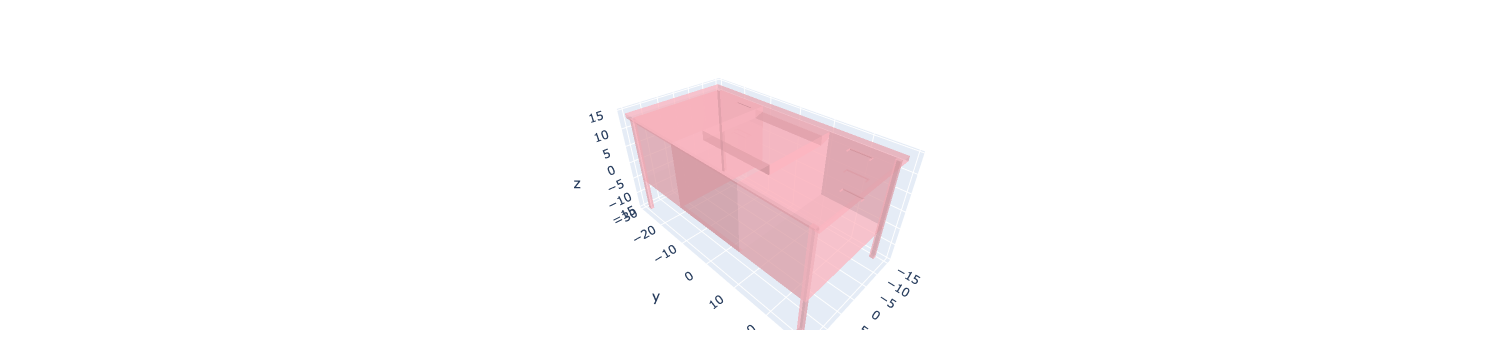

In [24]:
visualize_mesh_plotly(np.asarray(verts), faces_arr=np.asarray(faces))

Pero lo que queremos es convertirlo a una *nube de puntos*. Para ello definimos 2 funciones:

In [30]:
# Definimos una función que nos deja ver solamente los puntos del objeto
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig


def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

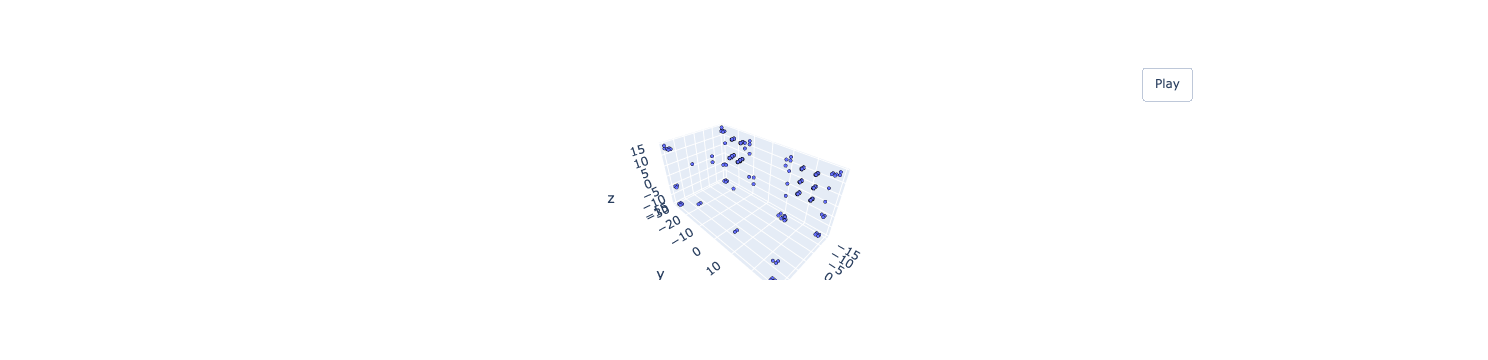

In [31]:
pcshow(*np.asarray(verts).T)


Esta es la representación de la imagenen como una **nube de puntos**.